# Object Detection using a subset of Pascal VOC dataset
Polytech SI4

Diane Lingrand Diane.Lingrand@univ-cotedazur.fr

2024-2025


In [1]:
import numpy as np
import torch
import random

In [3]:
import xml.etree.ElementTree as ET
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [5]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Reshape
from keras.layers import RandomContrast, RandomBrightness
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from skimage.transform import resize

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset

The images are similar to the images processed in previous labs (CNN, XAI). However, we also need the box coordinates. These informations are stored in the xml you already have downloaded but we need to read these informations for this lab.

The computations will be heavier than previously. If you do not own a GPU on your labtop, we strongly encourage you to work on google colab. If you have not already downloaded the CatDogBird dataset on your google drive, you can use my share directory (just create a shortcut to it): 

https://drive.google.com/drive/folders/1mvjR8HqD__VyVINltCzzqyPj3pu3RAv-?usp=sharing

In [9]:
homedir = 'C:\\Users\\abbon\\OneDrive\\Documents\\SI4\\deep_leaning\\TP5\\CatDogBird\\'

### Read the xml files for classes and box coordinates

In [12]:
classesNames=['cat','dog','bird']
nbClasses = len(classesNames)

listXml = glob.glob(homedir+'*.xml')
listImgFiles=[]
listLabels=[]
listBoxes=[]

for xml in listXml:
    bb = []
    tree = ET.parse(xml)
    doc = tree.getroot()
    nbObj = 0
    for d in doc.findall('.//object/name'):
        if d.text=='cat':
            listLabels.append(0)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='dog':
            listLabels.append(1)
            listImgFiles.append(xml[:-4]+'.jpg')
        elif d.text=='bird':
            listLabels.append(2)
            listImgFiles.append(xml[:-4]+'.jpg')
    # for this lab, we also need to load the box coordinates
    for d in doc.findall('.//object/bndbox/xmin'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/ymin'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/xmax'):
        bb.append(int(d.text))
    for d in doc.findall('.//object/bndbox/ymax'):
        bb.append(int(d.text))
        
    listBoxes.append(bb)


### Let's plot some images with the true box

Filename:  C:\Users\abbon\OneDrive\Documents\SI4\deep_leaning\TP5\CatDogBird\2008_000533.jpg
Coordinates:  [233, 116, 492, 268]
Image shape:  (357, 500, 3)


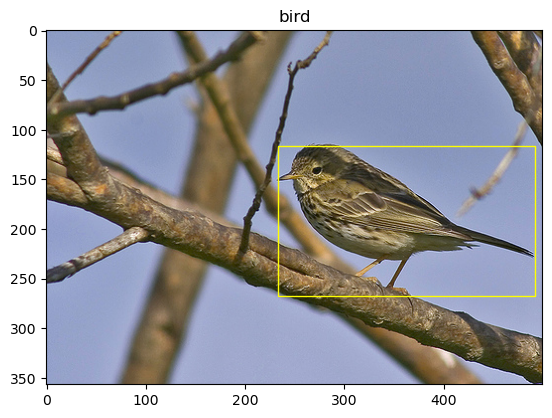

In [26]:
i = 90 # change this index to see other images with their boxes
filename = listImgFiles[i]
print('Filename: ',filename)
bb = listBoxes[i]
print('Coordinates: ',bb)
img = plt.imread(filename)
print('Image shape: ',img.shape)
plt.imshow(img)
plt.title(classesNames[listLabels[i]])
rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1], linewidth=1, edgecolor='yellow', facecolor='none')
plt.gca().add_patch(rect)

### Normalisation of boxes coordinates

In [28]:
nbData = len(listImgFiles)

X = np.empty(shape=(nbData,224,224,3))
yBoxes = np.empty(shape=(nbData,4),dtype=np.float32)
i = 0
for imageFilename in tqdm(listImgFiles): 
    theimage = plt.imread(imageFilename)
    h = theimage.shape[0]
    w = theimage.shape[1]
    img = resize(theimage,(224,224,3))
    im = image.img_to_array(img)
    im = np.expand_dims(im, axis=0)
    im = preprocess_input(im)
    X[i,:,:,:] = im
   
    yBoxes[i][0] = listBoxes[i][0]/w
    yBoxes[i][1] = listBoxes[i][1]/h
    yBoxes[i][2] = listBoxes[i][2]/w
    yBoxes[i][3] = listBoxes[i][3]/h
    
    i += 1


100%|██████████| 2007/2007 [00:55<00:00, 36.46it/s]


In [32]:
# listBoxes is no more necessary
del listBoxes

NameError: name 'listBoxes' is not defined

In [34]:
#train/test split
X_train, X_test, y_boxes_train, y_boxes_test, y_labels_train, y_labels_test, listImgFilesTrain, listImgFilesTest = train_test_split(X, yBoxes, listLabels, listImgFiles, test_size=0.2, random_state=42)

In [36]:
# these variables are no more necessary
del X, yBoxes, listLabels, listImgFiles

In [38]:
# convert to numpy arrays
y_labels_train = np.array(y_labels_train)
y_labels_test = np.array(y_labels_test)

In [40]:
print(np.unique(y_labels_train, return_counts=True))
print(np.unique(y_labels_test, return_counts=True))

(array([0, 1, 2]), array([605, 549, 451], dtype=int64))
(array([0, 1, 2]), array([140, 145, 117], dtype=int64))


In [42]:
yLabelsCategoricalTrain = keras.utils.to_categorical(y_labels_train, nbClasses)
yLabelsCategoricalTest = keras.utils.to_categorical(y_labels_test, nbClasses)

## Neural network model

<font color="green"><b>Question:</b></font> Here is a draft of a model. Add or modify layers.

In [54]:
VGGmodel = VGG16(weights='imagenet', input_shape=(224,224,3),include_top=False)
m = VGGmodel.get_layer('block5_conv3').output  # or VGGmodel.output
m = Conv2D(128,(1,1),padding='same',activation='relu')(m)
m = BatchNormalization()(m)
m = GlobalAveragePooling2D()(m)
m = Dense(1024, activation='relu')(m)
m = Dropout(0.5)(m)
m = Dense(512, activation='relu')(m)
m = Dropout(0.5)(m)
localisations = Dense(4, activation='sigmoid', name='boxLayer')(m)
predictions = Dense(nbClasses, activation='softmax', name='clLayer')(m)

model = Model(inputs = VGGmodel.input,outputs=[localisations, predictions])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,441,351 (58.90 MB)

 Trainable params: 15,441,095 (58.90 MB)

 Non-trainable params: 256 (1.00 KB)

In [72]:
num_classes = nbClasses  
y_labels_train_one_hot = keras.utils.to_categorical(y_labels_train, num_classes)
y_labels_test_one_hot = keras.utils.to_categorical(y_labels_test, num_classes)

<font color="green"><b>Question:</b></font> Count the number of parameters to be learned (freeze the VGG weights). Learn the added layers, measure the CO2 consumption, evaluate performance metrics and plot history.

In [80]:
# Freeze VGG16 layers
for layer in VGGmodel.layers:
    layer.trainable = False


# loss function is composed of 2 terms: one for the localisations and one for the predictions
model.compile(optimizer='adam', loss = ['mse','categorical_crossentropy'],metrics=['mse','accuracy'])

history = model.fit(
    X_train, [y_boxes_train, y_labels_train_one_hot],
    validation_data=(X_test, [y_boxes_test, y_labels_test_one_hot]),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Evaluate the model on test data
test_metrics = model.evaluate(X_test, [y_boxes_test, y_labels_test], verbose=0)
print(f"Test Loss (Localization): {test_metrics[1]}, Test Loss (Classification): {test_metrics[2]}")
print(f"Test MSE (Localization): {test_metrics[3]}, Test Accuracy (Classification): {test_metrics[4]}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['boxLayer_loss'], label='Localization Loss')
plt.plot(history.history['val_boxLayer_loss'], label='Val Localization Loss')
plt.legend()
plt.title('Localization Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['clLayer_accuracy'], label='Classification Accuracy')
plt.plot(history.history['val_clLayer_accuracy'], label='Val Classification Accuracy')
plt.legend()
plt.title('Classification Accuracy over Epochs')

plt.show()

Epoch 1/20


[codecarbon INFO @ 11:25:05] Energy consumed for RAM : 0.007397 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:25:05] Energy consumed for all GPUs : 0.013626 kWh. Total GPU Power : 15.074534336636752 W
[codecarbon INFO @ 11:25:05] Energy consumed for all CPUs : 0.028996 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:25:05] 0.050019 kWh of electricity used since the beginning.


 15/101 ━━━━━━━━━━━━━━━━━━━━ 1:17 901ms/step - boxLayer_loss: 0.0258 - boxLayer_mse: 0.0258 - clLayer_accuracy: 0.3836 - clLayer_loss: 1.0412 - loss: 1.0670

[codecarbon INFO @ 11:25:20] Energy consumed for RAM : 0.007421 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:25:20] Energy consumed for all GPUs : 0.013689 kWh. Total GPU Power : 15.256132404919276 W
[codecarbon INFO @ 11:25:20] Energy consumed for all CPUs : 0.029089 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:25:20] 0.050199 kWh of electricity used since the beginning.


 32/101 ━━━━━━━━━━━━━━━━━━━━ 1:01 887ms/step - boxLayer_loss: 0.0248 - boxLayer_mse: 0.0248 - clLayer_accuracy: 0.4084 - clLayer_loss: 1.0381 - loss: 1.0629

[codecarbon INFO @ 11:25:35] Energy consumed for RAM : 0.007446 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:25:35] Energy consumed for all GPUs : 0.013753 kWh. Total GPU Power : 15.3175120538021 W
[codecarbon INFO @ 11:25:35] Energy consumed for all CPUs : 0.029182 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:25:35] 0.050381 kWh of electricity used since the beginning.


 50/101 ━━━━━━━━━━━━━━━━━━━━ 44s 870ms/step - boxLayer_loss: 0.0246 - boxLayer_mse: 0.0246 - clLayer_accuracy: 0.4152 - clLayer_loss: 1.0376 - loss: 1.0623

[codecarbon INFO @ 11:25:50] Energy consumed for RAM : 0.007471 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:25:50] Energy consumed for all GPUs : 0.013816 kWh. Total GPU Power : 15.216044825601317 W
[codecarbon INFO @ 11:25:50] Energy consumed for all CPUs : 0.029276 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:25:50] 0.050563 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:25:50] 0.000677 g.CO2eq/s mean an estimation of 21.351480322607777 kg.CO2eq/year


 68/101 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4197 - clLayer_loss: 1.0371 - loss: 1.0616

[codecarbon INFO @ 11:26:05] Energy consumed for RAM : 0.007495 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:26:05] Energy consumed for all GPUs : 0.013879 kWh. Total GPU Power : 15.019881438145504 W
[codecarbon INFO @ 11:26:05] Energy consumed for all CPUs : 0.029370 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:26:05] 0.050744 kWh of electricity used since the beginning.


 85/101 ━━━━━━━━━━━━━━━━━━━━ 13s 864ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4228 - clLayer_loss: 1.0360 - loss: 1.0605

[codecarbon INFO @ 11:26:20] Energy consumed for RAM : 0.007520 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:26:20] Energy consumed for all GPUs : 0.013941 kWh. Total GPU Power : 14.923035117469295 W
[codecarbon INFO @ 11:26:20] Energy consumed for all CPUs : 0.029464 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:26:20] 0.050925 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4254 - clLayer_loss: 1.0347 - loss: 1.0592

[codecarbon INFO @ 11:26:35] Energy consumed for RAM : 0.007544 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:26:35] Energy consumed for all GPUs : 0.014003 kWh. Total GPU Power : 14.893829573996237 W
[codecarbon INFO @ 11:26:35] Energy consumed for all CPUs : 0.029558 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:26:35] 0.051106 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:26:50] Energy consumed for RAM : 0.007569 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:26:50] Energy consumed for all GPUs : 0.014065 kWh. Total GPU Power : 14.77024062972346 W
[codecarbon INFO @ 11:26:50] Energy consumed for all CPUs : 0.029652 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:26:50] 0.051286 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4256 - clLayer_loss: 1.0346 - loss: 1.0591 - val_boxLayer_loss: 0.0289 - val_boxLayer_mse: 0.0280 - val_clLayer_accuracy: 0.2985 - val_clLayer_loss: 1.8903 - val_loss: 1.9522
Epoch 2/20
 12/101 ━━━━━━━━━━━━━━━━━━━━ 1:14 834ms/step - boxLayer_loss: 0.0265 - boxLayer_mse: 0.0265 - clLayer_accuracy: 0.5236 - clLayer_loss: 0.9602 - loss: 0.9867

[codecarbon INFO @ 11:27:05] Energy consumed for RAM : 0.007594 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:27:05] Energy consumed for all GPUs : 0.014127 kWh. Total GPU Power : 14.898403322516018 W
[codecarbon INFO @ 11:27:05] Energy consumed for all CPUs : 0.029746 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:27:05] 0.051466 kWh of electricity used since the beginning.


 30/101 ━━━━━━━━━━━━━━━━━━━━ 58s 830ms/step - boxLayer_loss: 0.0250 - boxLayer_mse: 0.0250 - clLayer_accuracy: 0.4884 - clLayer_loss: 0.9923 - loss: 1.0174

[codecarbon INFO @ 11:27:20] Energy consumed for RAM : 0.007618 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:27:20] Energy consumed for all GPUs : 0.014189 kWh. Total GPU Power : 14.872585924148082 W
[codecarbon INFO @ 11:27:20] Energy consumed for all CPUs : 0.029839 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:27:20] 0.051647 kWh of electricity used since the beginning.


 48/101 ━━━━━━━━━━━━━━━━━━━━ 44s 835ms/step - boxLayer_loss: 0.0247 - boxLayer_mse: 0.0247 - clLayer_accuracy: 0.4792 - clLayer_loss: 0.9993 - loss: 1.0240

[codecarbon INFO @ 11:27:35] Energy consumed for RAM : 0.007643 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:27:35] Energy consumed for all GPUs : 0.014251 kWh. Total GPU Power : 14.739075498476927 W
[codecarbon INFO @ 11:27:35] Energy consumed for all CPUs : 0.029933 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:27:35] 0.051827 kWh of electricity used since the beginning.


 65/101 ━━━━━━━━━━━━━━━━━━━━ 30s 850ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4743 - clLayer_loss: 1.0058 - loss: 1.0303

[codecarbon INFO @ 11:27:50] Energy consumed for RAM : 0.007667 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:27:50] Energy consumed for all GPUs : 0.014312 kWh. Total GPU Power : 14.788117348235188 W
[codecarbon INFO @ 11:27:50] Energy consumed for all CPUs : 0.030027 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:27:50] 0.052007 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:27:50] 0.000673 g.CO2eq/s mean an estimation of 21.225636731777687 kg.CO2eq/year


 82/101 ━━━━━━━━━━━━━━━━━━━━ 16s 854ms/step - boxLayer_loss: 0.0243 - boxLayer_mse: 0.0243 - clLayer_accuracy: 0.4708 - clLayer_loss: 1.0100 - loss: 1.0343

[codecarbon INFO @ 11:28:05] Energy consumed for RAM : 0.007692 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:28:05] Energy consumed for all GPUs : 0.014374 kWh. Total GPU Power : 14.788920082632135 W
[codecarbon INFO @ 11:28:05] Energy consumed for all CPUs : 0.030121 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:28:05] 0.052187 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - boxLayer_loss: 0.0243 - boxLayer_mse: 0.0243 - clLayer_accuracy: 0.4690 - clLayer_loss: 1.0123 - loss: 1.0366

[codecarbon INFO @ 11:28:20] Energy consumed for RAM : 0.007717 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:28:20] Energy consumed for all GPUs : 0.014436 kWh. Total GPU Power : 14.847898890424492 W
[codecarbon INFO @ 11:28:20] Energy consumed for all CPUs : 0.030215 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:28:20] 0.052367 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:28:35] Energy consumed for RAM : 0.007741 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:28:35] Energy consumed for all GPUs : 0.014498 kWh. Total GPU Power : 14.794092640834192 W
[codecarbon INFO @ 11:28:35] Energy consumed for all CPUs : 0.030309 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:28:35] 0.052548 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - boxLayer_loss: 0.0243 - boxLayer_mse: 0.0243 - clLayer_accuracy: 0.4690 - clLayer_loss: 1.0124 - loss: 1.0367 - val_boxLayer_loss: 0.0308 - val_boxLayer_mse: 0.0295 - val_clLayer_accuracy: 0.2935 - val_clLayer_loss: 2.1783 - val_loss: 2.2372
Epoch 3/20
 12/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 824ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4453 - clLayer_loss: 1.0338 - loss: 1.0583

[codecarbon INFO @ 11:28:50] Energy consumed for RAM : 0.007766 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:28:50] Energy consumed for all GPUs : 0.014560 kWh. Total GPU Power : 14.806978141617533 W
[codecarbon INFO @ 11:28:50] Energy consumed for all CPUs : 0.030403 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:28:50] 0.052729 kWh of electricity used since the beginning.


 30/101 ━━━━━━━━━━━━━━━━━━━━ 58s 830ms/step - boxLayer_loss: 0.0246 - boxLayer_mse: 0.0246 - clLayer_accuracy: 0.4533 - clLayer_loss: 1.0286 - loss: 1.0532

[codecarbon INFO @ 11:29:05] Energy consumed for RAM : 0.007791 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:29:05] Energy consumed for all GPUs : 0.014622 kWh. Total GPU Power : 14.86584018332172 W
[codecarbon INFO @ 11:29:05] Energy consumed for all CPUs : 0.030497 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:29:05] 0.052909 kWh of electricity used since the beginning.


 48/101 ━━━━━━━━━━━━━━━━━━━━ 44s 831ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.4585 - clLayer_loss: 1.0246 - loss: 1.0491

[codecarbon INFO @ 11:29:21] Energy consumed for RAM : 0.007815 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:29:21] Energy consumed for all GPUs : 0.014684 kWh. Total GPU Power : 14.778709611848292 W
[codecarbon INFO @ 11:29:21] Energy consumed for all CPUs : 0.030592 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:29:21] 0.053090 kWh of electricity used since the beginning.


 66/101 ━━━━━━━━━━━━━━━━━━━━ 29s 830ms/step - boxLayer_loss: 0.0244 - boxLayer_mse: 0.0244 - clLayer_accuracy: 0.4598 - clLayer_loss: 1.0238 - loss: 1.0482

[codecarbon INFO @ 11:29:36] Energy consumed for RAM : 0.007840 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:29:36] Energy consumed for all GPUs : 0.014745 kWh. Total GPU Power : 14.868579946704726 W
[codecarbon INFO @ 11:29:36] Energy consumed for all CPUs : 0.030685 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:29:36] 0.053270 kWh of electricity used since the beginning.


 84/101 ━━━━━━━━━━━━━━━━━━━━ 14s 831ms/step - boxLayer_loss: 0.0243 - boxLayer_mse: 0.0243 - clLayer_accuracy: 0.4629 - clLayer_loss: 1.0217 - loss: 1.0460

[codecarbon INFO @ 11:29:51] Energy consumed for RAM : 0.007864 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:29:51] Energy consumed for all GPUs : 0.014808 kWh. Total GPU Power : 14.912382413242916 W
[codecarbon INFO @ 11:29:51] Energy consumed for all CPUs : 0.030779 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:29:51] 0.053451 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:29:51] 0.000673 g.CO2eq/s mean an estimation of 21.21499554355809 kg.CO2eq/year


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - boxLayer_loss: 0.0242 - boxLayer_mse: 0.0242 - clLayer_accuracy: 0.4645 - clLayer_loss: 1.0201 - loss: 1.0443

[codecarbon INFO @ 11:30:06] Energy consumed for RAM : 0.007889 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:30:06] Energy consumed for all GPUs : 0.014870 kWh. Total GPU Power : 14.837811555057998 W
[codecarbon INFO @ 11:30:06] Energy consumed for all CPUs : 0.030873 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:30:06] 0.053631 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:30:21] Energy consumed for RAM : 0.007913 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:30:21] Energy consumed for all GPUs : 0.014931 kWh. Total GPU Power : 14.793098929610055 W
[codecarbon INFO @ 11:30:21] Energy consumed for all CPUs : 0.030967 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:30:21] 0.053812 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0242 - boxLayer_mse: 0.0242 - clLayer_accuracy: 0.4647 - clLayer_loss: 1.0200 - loss: 1.0442 - val_boxLayer_loss: 0.0492 - val_boxLayer_mse: 0.0475 - val_clLayer_accuracy: 0.4129 - val_clLayer_loss: 1.4565 - val_loss: 1.5403
Epoch 4/20
 13/101 ━━━━━━━━━━━━━━━━━━━━ 1:13 839ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.4203 - clLayer_loss: 1.0490 - loss: 1.0724

[codecarbon INFO @ 11:30:36] Energy consumed for RAM : 0.007938 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:30:36] Energy consumed for all GPUs : 0.014993 kWh. Total GPU Power : 14.839042796618802 W
[codecarbon INFO @ 11:30:36] Energy consumed for all CPUs : 0.031061 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:30:36] 0.053993 kWh of electricity used since the beginning.


 31/101 ━━━━━━━━━━━━━━━━━━━━ 58s 833ms/step - boxLayer_loss: 0.0237 - boxLayer_mse: 0.0237 - clLayer_accuracy: 0.4532 - clLayer_loss: 1.0199 - loss: 1.0436

[codecarbon INFO @ 11:30:51] Energy consumed for RAM : 0.007963 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:30:51] Energy consumed for all GPUs : 0.015056 kWh. Total GPU Power : 14.882917221648302 W
[codecarbon INFO @ 11:30:51] Energy consumed for all CPUs : 0.031155 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:30:51] 0.054174 kWh of electricity used since the beginning.


 49/101 ━━━━━━━━━━━━━━━━━━━━ 43s 830ms/step - boxLayer_loss: 0.0235 - boxLayer_mse: 0.0235 - clLayer_accuracy: 0.4596 - clLayer_loss: 1.0131 - loss: 1.0366

[codecarbon INFO @ 11:31:06] Energy consumed for RAM : 0.007987 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:31:06] Energy consumed for all GPUs : 0.015117 kWh. Total GPU Power : 14.721450875234641 W
[codecarbon INFO @ 11:31:06] Energy consumed for all CPUs : 0.031249 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:31:06] 0.054354 kWh of electricity used since the beginning.


 67/101 ━━━━━━━━━━━━━━━━━━━━ 28s 828ms/step - boxLayer_loss: 0.0235 - boxLayer_mse: 0.0235 - clLayer_accuracy: 0.4658 - clLayer_loss: 1.0066 - loss: 1.0302

[codecarbon INFO @ 11:31:21] Energy consumed for RAM : 0.008012 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:31:21] Energy consumed for all GPUs : 0.015179 kWh. Total GPU Power : 14.841345059976431 W
[codecarbon INFO @ 11:31:21] Energy consumed for all CPUs : 0.031343 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:31:21] 0.054534 kWh of electricity used since the beginning.


 86/101 ━━━━━━━━━━━━━━━━━━━━ 12s 828ms/step - boxLayer_loss: 0.0235 - boxLayer_mse: 0.0235 - clLayer_accuracy: 0.4715 - clLayer_loss: 1.0040 - loss: 1.0275

[codecarbon INFO @ 11:31:36] Energy consumed for RAM : 0.008037 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:31:36] Energy consumed for all GPUs : 0.015241 kWh. Total GPU Power : 14.715587187474624 W
[codecarbon INFO @ 11:31:36] Energy consumed for all CPUs : 0.031437 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:31:36] 0.054714 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - boxLayer_loss: 0.0235 - boxLayer_mse: 0.0235 - clLayer_accuracy: 0.4749 - clLayer_loss: 1.0038 - loss: 1.0273

[codecarbon INFO @ 11:31:51] Energy consumed for RAM : 0.008061 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:31:51] Energy consumed for all GPUs : 0.015302 kWh. Total GPU Power : 14.699066946480412 W
[codecarbon INFO @ 11:31:51] Energy consumed for all CPUs : 0.031531 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:31:51] 0.054894 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:31:51] 0.000672 g.CO2eq/s mean an estimation of 21.190764404715267 kg.CO2eq/year
[codecarbon INFO @ 11:32:06] Energy consumed for RAM : 0.008086 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:32:06] Energy consumed for all GPUs : 0.015364 kWh. Total GPU Power : 14.789128060245538 W
[codecarbon INFO @ 11:32:06] Energy consumed for all CPUs : 0.031625 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:32:06] 0.055074 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0235 - boxLayer_mse: 0.0235 - clLayer_accuracy: 0.4752 - clLayer_loss: 1.0038 - loss: 1.0272 - val_boxLayer_loss: 0.0314 - val_boxLayer_mse: 0.0303 - val_clLayer_accuracy: 0.2910 - val_clLayer_loss: 4.1312 - val_loss: 4.2332
Epoch 5/20
 14/101 ━━━━━━━━━━━━━━━━━━━━ 1:11 826ms/step - boxLayer_loss: 0.0210 - boxLayer_mse: 0.0210 - clLayer_accuracy: 0.4530 - clLayer_loss: 1.0103 - loss: 1.0313

[codecarbon INFO @ 11:32:21] Energy consumed for RAM : 0.008110 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:32:21] Energy consumed for all GPUs : 0.015425 kWh. Total GPU Power : 14.747170998708269 W
[codecarbon INFO @ 11:32:21] Energy consumed for all CPUs : 0.031719 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:32:21] 0.055254 kWh of electricity used since the beginning.


 32/101 ━━━━━━━━━━━━━━━━━━━━ 57s 836ms/step - boxLayer_loss: 0.0215 - boxLayer_mse: 0.0215 - clLayer_accuracy: 0.4634 - clLayer_loss: 1.0082 - loss: 1.0297

[codecarbon INFO @ 11:32:36] Energy consumed for RAM : 0.008135 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:32:36] Energy consumed for all GPUs : 0.015487 kWh. Total GPU Power : 14.817530410407167 W
[codecarbon INFO @ 11:32:36] Energy consumed for all CPUs : 0.031813 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:32:36] 0.055435 kWh of electricity used since the beginning.


 50/101 ━━━━━━━━━━━━━━━━━━━━ 42s 837ms/step - boxLayer_loss: 0.0219 - boxLayer_mse: 0.0219 - clLayer_accuracy: 0.4683 - clLayer_loss: 1.0052 - loss: 1.0271

[codecarbon INFO @ 11:32:51] Energy consumed for RAM : 0.008160 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:32:51] Energy consumed for all GPUs : 0.015549 kWh. Total GPU Power : 14.757334375741191 W
[codecarbon INFO @ 11:32:51] Energy consumed for all CPUs : 0.031907 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:32:51] 0.055615 kWh of electricity used since the beginning.


 68/101 ━━━━━━━━━━━━━━━━━━━━ 27s 837ms/step - boxLayer_loss: 0.0223 - boxLayer_mse: 0.0223 - clLayer_accuracy: 0.4728 - clLayer_loss: 1.0035 - loss: 1.0258

[codecarbon INFO @ 11:33:06] Energy consumed for RAM : 0.008184 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:33:06] Energy consumed for all GPUs : 0.015611 kWh. Total GPU Power : 14.840363119355874 W
[codecarbon INFO @ 11:33:06] Energy consumed for all CPUs : 0.032001 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:33:06] 0.055796 kWh of electricity used since the beginning.


 86/101 ━━━━━━━━━━━━━━━━━━━━ 12s 835ms/step - boxLayer_loss: 0.0225 - boxLayer_mse: 0.0225 - clLayer_accuracy: 0.4753 - clLayer_loss: 1.0032 - loss: 1.0257

[codecarbon INFO @ 11:33:21] Energy consumed for RAM : 0.008209 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:33:21] Energy consumed for all GPUs : 0.015672 kWh. Total GPU Power : 14.765895265074285 W
[codecarbon INFO @ 11:33:21] Energy consumed for all CPUs : 0.032095 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:33:21] 0.055976 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - boxLayer_loss: 0.0226 - boxLayer_mse: 0.0226 - clLayer_accuracy: 0.4766 - clLayer_loss: 1.0025 - loss: 1.0251

[codecarbon INFO @ 11:33:36] Energy consumed for RAM : 0.008234 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:33:36] Energy consumed for all GPUs : 0.015734 kWh. Total GPU Power : 14.844522976397178 W
[codecarbon INFO @ 11:33:36] Energy consumed for all CPUs : 0.032189 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:33:36] 0.056157 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:33:51] Energy consumed for RAM : 0.008258 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:33:51] Energy consumed for all GPUs : 0.015796 kWh. Total GPU Power : 14.735316983144472 W
[codecarbon INFO @ 11:33:51] Energy consumed for all CPUs : 0.032283 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:33:51] 0.056337 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:33:51] 0.000672 g.CO2eq/s mean an estimation of 21.192127410284115 kg.CO2eq/year


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0226 - boxLayer_mse: 0.0226 - clLayer_accuracy: 0.4767 - clLayer_loss: 1.0024 - loss: 1.0251 - val_boxLayer_loss: 0.0319 - val_boxLayer_mse: 0.0308 - val_clLayer_accuracy: 0.3433 - val_clLayer_loss: 1.4292 - val_loss: 1.4797
Epoch 6/20
 15/101 ━━━━━━━━━━━━━━━━━━━━ 1:12 841ms/step - boxLayer_loss: 0.0276 - boxLayer_mse: 0.0276 - clLayer_accuracy: 0.5327 - clLayer_loss: 0.9924 - loss: 1.0200

[codecarbon INFO @ 11:34:06] Energy consumed for RAM : 0.008283 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:34:06] Energy consumed for all GPUs : 0.015858 kWh. Total GPU Power : 14.805634965292088 W
[codecarbon INFO @ 11:34:06] Energy consumed for all CPUs : 0.032377 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:34:06] 0.056518 kWh of electricity used since the beginning.


 33/101 ━━━━━━━━━━━━━━━━━━━━ 56s 836ms/step - boxLayer_loss: 0.0253 - boxLayer_mse: 0.0253 - clLayer_accuracy: 0.5374 - clLayer_loss: 0.9851 - loss: 1.0103

[codecarbon INFO @ 11:34:21] Energy consumed for RAM : 0.008307 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:34:21] Energy consumed for all GPUs : 0.015919 kWh. Total GPU Power : 14.730291781543428 W
[codecarbon INFO @ 11:34:21] Energy consumed for all CPUs : 0.032471 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:34:21] 0.056698 kWh of electricity used since the beginning.


 51/101 ━━━━━━━━━━━━━━━━━━━━ 41s 834ms/step - boxLayer_loss: 0.0248 - boxLayer_mse: 0.0248 - clLayer_accuracy: 0.5252 - clLayer_loss: 0.9971 - loss: 1.0219

[codecarbon INFO @ 11:34:36] Energy consumed for RAM : 0.008332 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:34:36] Energy consumed for all GPUs : 0.015981 kWh. Total GPU Power : 14.731318274447064 W
[codecarbon INFO @ 11:34:36] Energy consumed for all CPUs : 0.032565 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:34:36] 0.056877 kWh of electricity used since the beginning.


 69/101 ━━━━━━━━━━━━━━━━━━━━ 26s 834ms/step - boxLayer_loss: 0.0246 - boxLayer_mse: 0.0246 - clLayer_accuracy: 0.5207 - clLayer_loss: 1.0011 - loss: 1.0257

[codecarbon INFO @ 11:34:51] Energy consumed for RAM : 0.008357 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:34:51] Energy consumed for all GPUs : 0.016042 kWh. Total GPU Power : 14.722865547624508 W
[codecarbon INFO @ 11:34:51] Energy consumed for all CPUs : 0.032658 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:34:51] 0.057057 kWh of electricity used since the beginning.


 87/101 ━━━━━━━━━━━━━━━━━━━━ 11s 835ms/step - boxLayer_loss: 0.0245 - boxLayer_mse: 0.0245 - clLayer_accuracy: 0.5165 - clLayer_loss: 1.0029 - loss: 1.0275

[codecarbon INFO @ 11:35:06] Energy consumed for RAM : 0.008381 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:35:06] Energy consumed for all GPUs : 0.016104 kWh. Total GPU Power : 14.842504494124373 W
[codecarbon INFO @ 11:35:06] Energy consumed for all CPUs : 0.032752 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:35:06] 0.057238 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - boxLayer_loss: 0.0244 - boxLayer_mse: 0.0244 - clLayer_accuracy: 0.5137 - clLayer_loss: 1.0035 - loss: 1.0279

[codecarbon INFO @ 11:35:21] Energy consumed for RAM : 0.008406 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:35:21] Energy consumed for all GPUs : 0.016165 kWh. Total GPU Power : 14.71745379848492 W
[codecarbon INFO @ 11:35:21] Energy consumed for all CPUs : 0.032846 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:35:21] 0.057418 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:35:36] Energy consumed for RAM : 0.008430 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:35:36] Energy consumed for all GPUs : 0.016227 kWh. Total GPU Power : 14.767777140258733 W
[codecarbon INFO @ 11:35:36] Energy consumed for all CPUs : 0.032940 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:35:36] 0.057597 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - boxLayer_loss: 0.0244 - boxLayer_mse: 0.0244 - clLayer_accuracy: 0.5135 - clLayer_loss: 1.0035 - loss: 1.0279 - val_boxLayer_loss: 0.0267 - val_boxLayer_mse: 0.0258 - val_clLayer_accuracy: 0.3333 - val_clLayer_loss: 1.2788 - val_loss: 1.3167
Epoch 7/20
 16/101 ━━━━━━━━━━━━━━━━━━━━ 1:10 830ms/step - boxLayer_loss: 0.0231 - boxLayer_mse: 0.0231 - clLayer_accuracy: 0.4377 - clLayer_loss: 1.0296 - loss: 1.0527

[codecarbon INFO @ 11:35:51] Energy consumed for RAM : 0.008455 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:35:51] Energy consumed for all GPUs : 0.016289 kWh. Total GPU Power : 14.806612597499154 W
[codecarbon INFO @ 11:35:51] Energy consumed for all CPUs : 0.033034 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:35:51] 0.057778 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:35:51] 0.000672 g.CO2eq/s mean an estimation of 21.179736697488718 kg.CO2eq/year


 34/101 ━━━━━━━━━━━━━━━━━━━━ 55s 828ms/step - boxLayer_loss: 0.0233 - boxLayer_mse: 0.0233 - clLayer_accuracy: 0.4384 - clLayer_loss: 1.0362 - loss: 1.0594

[codecarbon INFO @ 11:36:06] Energy consumed for RAM : 0.008480 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:36:07] Energy consumed for all GPUs : 0.016351 kWh. Total GPU Power : 14.79810348392608 W
[codecarbon INFO @ 11:36:07] Energy consumed for all CPUs : 0.033128 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:36:07] 0.057958 kWh of electricity used since the beginning.


 53/101 ━━━━━━━━━━━━━━━━━━━━ 39s 828ms/step - boxLayer_loss: 0.0236 - boxLayer_mse: 0.0236 - clLayer_accuracy: 0.4432 - clLayer_loss: 1.0362 - loss: 1.0599

[codecarbon INFO @ 11:36:22] Energy consumed for RAM : 0.008504 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:36:22] Energy consumed for all GPUs : 0.016413 kWh. Total GPU Power : 14.84044517438474 W
[codecarbon INFO @ 11:36:22] Energy consumed for all CPUs : 0.033222 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:36:22] 0.058139 kWh of electricity used since the beginning.


 71/101 ━━━━━━━━━━━━━━━━━━━━ 24s 827ms/step - boxLayer_loss: 0.0238 - boxLayer_mse: 0.0238 - clLayer_accuracy: 0.4469 - clLayer_loss: 1.0336 - loss: 1.0574

[codecarbon INFO @ 11:36:37] Energy consumed for RAM : 0.008529 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:36:37] Energy consumed for all GPUs : 0.016474 kWh. Total GPU Power : 14.780162815604504 W
[codecarbon INFO @ 11:36:37] Energy consumed for all CPUs : 0.033316 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:36:37] 0.058319 kWh of electricity used since the beginning.


 89/101 ━━━━━━━━━━━━━━━━━━━━ 9s 827ms/step - boxLayer_loss: 0.0240 - boxLayer_mse: 0.0240 - clLayer_accuracy: 0.4502 - clLayer_loss: 1.0302 - loss: 1.0542 

[codecarbon INFO @ 11:36:52] Energy consumed for RAM : 0.008554 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:36:52] Energy consumed for all GPUs : 0.016536 kWh. Total GPU Power : 14.879205414773315 W
[codecarbon INFO @ 11:36:52] Energy consumed for all CPUs : 0.033410 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:36:52] 0.058500 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - boxLayer_loss: 0.0240 - boxLayer_mse: 0.0240 - clLayer_accuracy: 0.4524 - clLayer_loss: 1.0282 - loss: 1.0522

[codecarbon INFO @ 11:37:07] Energy consumed for RAM : 0.008578 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:37:07] Energy consumed for all GPUs : 0.016598 kWh. Total GPU Power : 14.792827160512337 W
[codecarbon INFO @ 11:37:07] Energy consumed for all CPUs : 0.033504 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:37:07] 0.058681 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0240 - boxLayer_mse: 0.0240 - clLayer_accuracy: 0.4526 - clLayer_loss: 1.0281 - loss: 1.0520 - val_boxLayer_loss: 0.0260 - val_boxLayer_mse: 0.0251 - val_clLayer_accuracy: 0.3358 - val_clLayer_loss: 1.3120 - val_loss: 1.3526
Epoch 8/20


[codecarbon INFO @ 11:37:22] Energy consumed for RAM : 0.008603 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:37:22] Energy consumed for all GPUs : 0.016661 kWh. Total GPU Power : 14.923498177787202 W
[codecarbon INFO @ 11:37:22] Energy consumed for all CPUs : 0.033598 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:37:22] 0.058862 kWh of electricity used since the beginning.


 18/101 ━━━━━━━━━━━━━━━━━━━━ 1:08 829ms/step - boxLayer_loss: 0.0257 - boxLayer_mse: 0.0257 - clLayer_accuracy: 0.4931 - clLayer_loss: 0.9950 - loss: 1.0207

[codecarbon INFO @ 11:37:37] Energy consumed for RAM : 0.008628 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:37:37] Energy consumed for all GPUs : 0.016723 kWh. Total GPU Power : 14.847122268622451 W
[codecarbon INFO @ 11:37:37] Energy consumed for all CPUs : 0.033692 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:37:37] 0.059042 kWh of electricity used since the beginning.


 36/101 ━━━━━━━━━━━━━━━━━━━━ 53s 829ms/step - boxLayer_loss: 0.0244 - boxLayer_mse: 0.0244 - clLayer_accuracy: 0.4992 - clLayer_loss: 0.9911 - loss: 1.0155

[codecarbon INFO @ 11:37:52] Energy consumed for RAM : 0.008652 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:37:52] Energy consumed for all GPUs : 0.016785 kWh. Total GPU Power : 14.952013101402716 W
[codecarbon INFO @ 11:37:52] Energy consumed for all CPUs : 0.033786 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:37:52] 0.059223 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:37:52] 0.000673 g.CO2eq/s mean an estimation of 21.225854334952928 kg.CO2eq/year


 54/101 ━━━━━━━━━━━━━━━━━━━━ 38s 829ms/step - boxLayer_loss: 0.0241 - boxLayer_mse: 0.0241 - clLayer_accuracy: 0.4984 - clLayer_loss: 0.9912 - loss: 1.0153

[codecarbon INFO @ 11:38:07] Energy consumed for RAM : 0.008677 kWh. RAM Power : 5.898177623748779 W


 55/101 ━━━━━━━━━━━━━━━━━━━━ 38s 829ms/step - boxLayer_loss: 0.0241 - boxLayer_mse: 0.0241 - clLayer_accuracy: 0.4985 - clLayer_loss: 0.9912 - loss: 1.0152

[codecarbon INFO @ 11:38:07] Energy consumed for all GPUs : 0.016847 kWh. Total GPU Power : 14.81406190072244 W
[codecarbon INFO @ 11:38:07] Energy consumed for all CPUs : 0.033880 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:38:07] 0.059403 kWh of electricity used since the beginning.


 73/101 ━━━━━━━━━━━━━━━━━━━━ 23s 829ms/step - boxLayer_loss: 0.0239 - boxLayer_mse: 0.0239 - clLayer_accuracy: 0.4995 - clLayer_loss: 0.9904 - loss: 1.0143

[codecarbon INFO @ 11:38:22] Energy consumed for RAM : 0.008701 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:38:22] Energy consumed for all GPUs : 0.016909 kWh. Total GPU Power : 14.77491122406668 W
[codecarbon INFO @ 11:38:22] Energy consumed for all CPUs : 0.033974 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:38:22] 0.059584 kWh of electricity used since the beginning.


 91/101 ━━━━━━━━━━━━━━━━━━━━ 8s 830ms/step - boxLayer_loss: 0.0238 - boxLayer_mse: 0.0238 - clLayer_accuracy: 0.4985 - clLayer_loss: 0.9910 - loss: 1.0148

[codecarbon INFO @ 11:38:37] Energy consumed for RAM : 0.008726 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:38:37] Energy consumed for all GPUs : 0.016971 kWh. Total GPU Power : 14.853016359982085 W
[codecarbon INFO @ 11:38:37] Energy consumed for all CPUs : 0.034068 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:38:37] 0.059764 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - boxLayer_loss: 0.0238 - boxLayer_mse: 0.0238 - clLayer_accuracy: 0.4980 - clLayer_loss: 0.9910 - loss: 1.0148

[codecarbon INFO @ 11:38:52] Energy consumed for RAM : 0.008751 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:38:52] Energy consumed for all GPUs : 0.017032 kWh. Total GPU Power : 14.82646867503464 W
[codecarbon INFO @ 11:38:52] Energy consumed for all CPUs : 0.034162 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:38:52] 0.059945 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0238 - boxLayer_mse: 0.0238 - clLayer_accuracy: 0.4980 - clLayer_loss: 0.9910 - loss: 1.0148 - val_boxLayer_loss: 0.0337 - val_boxLayer_mse: 0.0328 - val_clLayer_accuracy: 0.4453 - val_clLayer_loss: 1.7200 - val_loss: 1.8011
Epoch 9/20
  2/101 ━━━━━━━━━━━━━━━━━━━━ 1:25 859ms/step - boxLayer_loss: 0.0196 - boxLayer_mse: 0.0196 - clLayer_accuracy: 0.5781 - clLayer_loss: 0.9012 - loss: 0.9207

[codecarbon INFO @ 11:39:07] Energy consumed for RAM : 0.008775 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:39:07] Energy consumed for all GPUs : 0.017094 kWh. Total GPU Power : 14.873114103235146 W
[codecarbon INFO @ 11:39:07] Energy consumed for all CPUs : 0.034256 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:39:07] 0.060125 kWh of electricity used since the beginning.


 20/101 ━━━━━━━━━━━━━━━━━━━━ 1:07 831ms/step - boxLayer_loss: 0.0224 - boxLayer_mse: 0.0224 - clLayer_accuracy: 0.5401 - clLayer_loss: 0.9456 - loss: 0.9680

[codecarbon INFO @ 11:39:22] Energy consumed for RAM : 0.008800 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:39:22] Energy consumed for all GPUs : 0.017156 kWh. Total GPU Power : 14.736164390357699 W
[codecarbon INFO @ 11:39:22] Energy consumed for all CPUs : 0.034350 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:39:22] 0.060306 kWh of electricity used since the beginning.


 38/101 ━━━━━━━━━━━━━━━━━━━━ 52s 826ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.5105 - clLayer_loss: 0.9641 - loss: 0.9875

[codecarbon INFO @ 11:39:37] Energy consumed for RAM : 0.008824 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:39:37] Energy consumed for all GPUs : 0.017218 kWh. Total GPU Power : 14.866299933985045 W
[codecarbon INFO @ 11:39:37] Energy consumed for all CPUs : 0.034444 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:39:37] 0.060486 kWh of electricity used since the beginning.


 56/101 ━━━━━━━━━━━━━━━━━━━━ 37s 829ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.5014 - clLayer_loss: 0.9710 - loss: 0.9944

[codecarbon INFO @ 11:39:52] Energy consumed for RAM : 0.008849 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:39:52] Energy consumed for all GPUs : 0.017280 kWh. Total GPU Power : 14.797941940673711 W
[codecarbon INFO @ 11:39:52] Energy consumed for all CPUs : 0.034538 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:39:52] 0.060667 kWh of electricity used since the beginning.
[codecarbon INFO @ 11:39:52] 0.000672 g.CO2eq/s mean an estimation of 21.20298896549094 kg.CO2eq/year


 74/101 ━━━━━━━━━━━━━━━━━━━━ 22s 828ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.4985 - clLayer_loss: 0.9749 - loss: 0.9983

[codecarbon INFO @ 11:40:07] Energy consumed for RAM : 0.008874 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:40:07] Energy consumed for all GPUs : 0.017342 kWh. Total GPU Power : 14.839178289204467 W
[codecarbon INFO @ 11:40:07] Energy consumed for all CPUs : 0.034631 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:40:07] 0.060847 kWh of electricity used since the beginning.


 93/101 ━━━━━━━━━━━━━━━━━━━━ 6s 828ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.4970 - clLayer_loss: 0.9774 - loss: 1.0008

[codecarbon INFO @ 11:40:22] Energy consumed for RAM : 0.008898 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:40:22] Energy consumed for all GPUs : 0.017403 kWh. Total GPU Power : 14.796934487285199 W
[codecarbon INFO @ 11:40:22] Energy consumed for all CPUs : 0.034725 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:40:22] 0.061027 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.4970 - clLayer_loss: 0.9779 - loss: 1.0013

[codecarbon INFO @ 11:40:37] Energy consumed for RAM : 0.008923 kWh. RAM Power : 5.898177623748779 W
[codecarbon INFO @ 11:40:37] Energy consumed for all GPUs : 0.017465 kWh. Total GPU Power : 14.852584392775531 W
[codecarbon INFO @ 11:40:37] Energy consumed for all CPUs : 0.034819 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 11:40:37] 0.061208 kWh of electricity used since the beginning.


101/101 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - boxLayer_loss: 0.0234 - boxLayer_mse: 0.0234 - clLayer_accuracy: 0.4970 - clLayer_loss: 0.9780 - loss: 1.0014 - val_boxLayer_loss: 0.0286 - val_boxLayer_mse: 0.0274 - val_clLayer_accuracy: 0.2910 - val_clLayer_loss: 3.6382 - val_loss: 3.6972


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 3)

<font color="green"><b>Question:</b></font> Are you satisfied with the results? Try to improve the network. You can make use of the learning techniques we have seen: dropout, batch normalisation, data augmentation (be careful with the impact of geometrical augmentation for the boxes coordinates).

In [ ]:
# your work here

### Display the result on test images with true box, predicted box, true class and predicted class

<font color="green"><b>Question:</b></font> Previously, a cell was responsible of displaying an image with the true box. Add the predicted box. Add a title with true and predicted classes. Hint: don't forget to multiply coordinates of boxes by true image dimension of the image.

In [ ]:
# your work

## Waiting for the network to converge
When your computer is working for you, you have time to answer the following questions.

### lower bound for accuracy

<font color="green"><b>Question:</b></font> Do you remember the value of accuracy if prediction is random or if the prediction is always the majority class?

In [ ]:
# your work here

### error of one pixel for bounding box

<font color="green"><b>Question:</b></font> We consider the output features of layer 'block5_conv3'. Imagine that the prediction has an error of 1 pixel in the 14*14 feature maps. What is the mse value in this case?

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> Same question if we used the 7x7x512 output features of VGG16

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> Same question for the IoU metric.

In [ ]:
# your work here

## Using an IoU loss

### first, let's compute iuo for simple boxes

Here is some code. Do you think it computes the IoU correctly?

In [ ]:
a = np.array([1,1,3,3])
b = np.array([2,2,4,4])
c = np.array([5,5,7,7])
d = np.array([6,6,8,8])
e = np.array([3,3,1,1])
f = np.array([4,4,2,2])

yt = np.array([a,c,e])
yp = np.array([b,d,f])
yt.shape

In [ ]:
def iou(y_true,y_pred):
    # order the coordinates if needed
    xt0 = np.min(y_true[:,[0,2]],axis=1)
    xt1 = np.max(y_true[:,[0,2]],axis=1)
    yt0 = np.min(y_true[:,[1,3]],axis=1)
    yt1 = np.max(y_true[:,[1,3]],axis=1)

    xp0 = np.min(y_pred[:,[0,2]],axis=1)
    xp1 = np.max(y_pred[:,[0,2]],axis=1)
    yp0 = np.min(y_pred[:,[1,3]],axis=1)
    yp1 = np.max(y_pred[:,[1,3]],axis=1)

    # area of each box
    true_area =(xt1-xt0)*(yt1-yt0)
    pred_area = (xp1-xp0)*(yp1-yp0)

    #coordinates of the intersection area
    ixmax = np.minimum(xt1,xp1)
    iymax = np.minimum(yt1,yp1)
    ixmin = np.maximum(xt0,xp0)
    iymin = np.maximum(yt0,yp0)
  
    # test if there is an intersection (otherwise intersection = 0)
    iw = np.clip(ixmax - ixmin, a_min=0, a_max=None)
    ih = np.clip(iymax - iymin, a_min=0, a_max=None)

    # intersection area
    inter_area = iw*ih
    union_area = true_area + pred_area - inter_area

    # nan or inf could be returned here
    return np.mean(inter_area/union_area)

In [ ]:
iou(yt,yp)

### then define a IoU loss by inheritence of Loss class

If the code is correct, this is the way to transform it to a loss function.

In [30]:
from keras.losses import Loss

class InterOverUnion(Loss):
    def call(self, y_true, y_pred):
        # order the coordinates if needed
        xt0 = torch.min(y_true[:,[0,2]],axis=1).values
        xt1 = torch.max(y_true[:,[0,2]],axis=1).values
        yt0 = torch.min(y_true[:,[1,3]],axis=1).values
        yt1 = torch.max(y_true[:,[1,3]],axis=1).values

        xp0 = torch.min(y_pred[:,[0,2]],axis=1).values
        xp1 = torch.max(y_pred[:,[0,2]],axis=1).values
        yp0 = torch.min(y_pred[:,[1,3]],axis=1).values
        yp1 = torch.max(y_pred[:,[1,3]],axis=1).values

        # area of each box
        true_area = (xt1-xt0)*(yt1-yt0)
        pred_area = (xp1-xp0)*(yp1-yp0)

        #coordinates of the intersection area
        ixmax = torch.minimum(xt1,xp1)
        iymax = torch.minimum(yt1,yp1)
        ixmin = torch.maximum(xt0,xp0)
        iymin = torch.maximum(yt0,yp0)

        # test if there is an intersection (otherwise intersection = 0)
        iw = torch.clamp(ixmax - ixmin, min=0, max=None)
        ih = torch.clamp(iymax - iymin, min=0, max=None)

        # intersection area
        inter_area = iw*ih

        # union area as some of areas of boxes - intersection (otherwise counted twice)
        union_area = true_area + pred_area - inter_area
        # be careful of division by 0
        iou = inter_area / (union_area+keras.backend.epsilon())
 
        # different options: -log(iou), 1-iou ....
        return torch.mean(-torch.log(iou))

<font color="green"><b>Question:</b></font> Let's play with this new loss! Learn the neural network by modifying the 'mse' loss to this new IoU loss. As usual, compute metrics.

In [ ]:
# your work here

<font color="green"><b>Question:</b></font> What is the IoU value if the boxes do not have any intersection. In this case, how can the loss function help to modify the boxes coordinates?

In [ ]:
# your work here